####our choosed dataset is flight data between 6 airport and contain more than 300k records. we set our goal to predict the arrival delay of flights.


In [65]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
# pip --default-timeout=100 install django

##if you had any problem downloading below dataset, run upper block.

In [3]:
df = sm.datasets.get_rdataset('flights', 'nycflights13').data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

In [4]:
df.head(10)


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z
5,2013,1,1,554.0,558,-4.0,740.0,728,12.0,UA,1696,N39463,EWR,ORD,150.0,719,5,58,2013-01-01T10:00:00Z
6,2013,1,1,555.0,600,-5.0,913.0,854,19.0,B6,507,N516JB,EWR,FLL,158.0,1065,6,0,2013-01-01T11:00:00Z
7,2013,1,1,557.0,600,-3.0,709.0,723,-14.0,EV,5708,N829AS,LGA,IAD,53.0,229,6,0,2013-01-01T11:00:00Z
8,2013,1,1,557.0,600,-3.0,838.0,846,-8.0,B6,79,N593JB,JFK,MCO,140.0,944,6,0,2013-01-01T11:00:00Z
9,2013,1,1,558.0,600,-2.0,753.0,745,8.0,AA,301,N3ALAA,LGA,ORD,138.0,733,6,0,2013-01-01T11:00:00Z


##first let's check for null values:

In [5]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

##because Null values is just 3% of our dataset, it's ok to simply ignore them:

In [6]:
df.dropna(inplace=True)

##now let's deal with date/time!
##we have departure time, arrival time and delay; and they are scattered around the table. so first, lets make two new python standard date/time column for departure and arrival time and standardize delay time (in minutes)and remove all leftovers:
##note: of course having departure and delay, we can compute arrival time. but arrival time could perhaps have some information in it and it is good to have a different column for it.


In [7]:
temp_df = pd.DataFrame()
#change to integers
temp_df['dep_time'] = df['dep_time'].astype(str).str.split('.').str[0].astype(int)
temp_df['dep_time'] = temp_df['dep_time'].apply(lambda x: f'{x:04d}')

#take out date and time
temp_df['hour'] = temp_df['dep_time'].str[:2].astype(int)
temp_df['minute'] = temp_df['dep_time'].str[2:].astype(int)

#adding other needed columns to temp_df
temp_df['year'] = df['year']
temp_df['month'] = df['month']
temp_df['day'] = df['day']

#generate standard date_time column for departure time:
df['Std_Departure_Date'] = pd.to_datetime(temp_df[['year','month','day','hour','minute']])


In [8]:
#adding new columns
df['Year'] = df['Std_Departure_Date'].dt.year
df['Month'] = df['Std_Departure_Date'].dt.month
df['Day'] = df['Std_Departure_Date'].dt.day
df['Season'] = df['Std_Departure_Date'].dt.quarter
df['Day_of_Week'] = df['Std_Departure_Date'].dt.dayofweek
df['Departure_hour'] = df['Std_Departure_Date'].dt.hour
df['Departure_min'] = df['Std_Departure_Date'].dt.minute


In [9]:
#drop old date and time columns:
df.drop(columns=['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'hour','minute'], inplace=True)


##arrival time is stored already in 'arr_time' column. we will generate three new columns; one is standard datetime for arrival and two others are hour and minute.

In [10]:
temp_df = pd.DataFrame()

#extracting year-month-day of arrival
temp_df['temp_date'] = pd.to_datetime(df['time_hour'])
temp_df['Year'] = temp_df['temp_date'].dt.year
temp_df['Month'] = temp_df['temp_date'].dt.month
temp_df['Day'] = temp_df['temp_date'].dt.day

#extracting time of arrival
temp_df['arr_time'] = df['arr_time'].astype(int)
temp_df['arr_time'] = temp_df['arr_time'].astype(str).str.zfill(4)
temp_df['hour'] = temp_df['arr_time'].str[:2].astype(int)
temp_df['minute'] = temp_df['arr_time'].str[2:].astype(int)

#generate standard date_time column for arrival time:
df['Std_Arrival_Date'] = pd.to_datetime(temp_df[['Year','Month','Day','hour','minute']])
df['Arrival_hour'] = df['Std_Arrival_Date'].dt.hour
df['Arrival_min'] = df['Std_Arrival_Date'].dt.minute



In [11]:
#drop old date and time columns:
df.drop(columns=['arr_time', 'sched_arr_time','time_hour'], inplace=True)

In [12]:
df.head(3)

,dep_delay,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,Std_Departure_Date,Year,Month,Day,Season,Day_of_Week,Departure_hour,Departure_min,Std_Arrival_Date,Arrival_hour,Arrival_min
0,2.0,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,2013-01-01 05:17:00,2013,1,1,1,1,5,17,2013-01-01 08:30:00,8,30
1,4.0,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,2013-01-01 05:33:00,2013,1,1,1,1,5,33,2013-01-01 08:50:00,8,50
2,2.0,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,2013-01-01 05:42:00,2013,1,1,1,1,5,42,2013-01-01 09:23:00,9,23


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327346 entries, 0 to 336769
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   dep_delay           327346 non-null  float64       
 1   arr_delay           327346 non-null  float64       
 2   carrier             327346 non-null  object        
 3   flight              327346 non-null  int64         
 4   tailnum             327346 non-null  object        
 5   origin              327346 non-null  object        
 6   dest                327346 non-null  object        
 7   air_time            327346 non-null  float64       
 8   distance            327346 non-null  int64         
 9   Std_Departure_Date  327346 non-null  datetime64[ns]
 10  Year                327346 non-null  int64         
 11  Month               327346 non-null  int64         
 12  Day                 327346 non-null  int64         
 13  Season              327346 no

##okay! now let's take some insight on the relationship between the available information and the flight delay

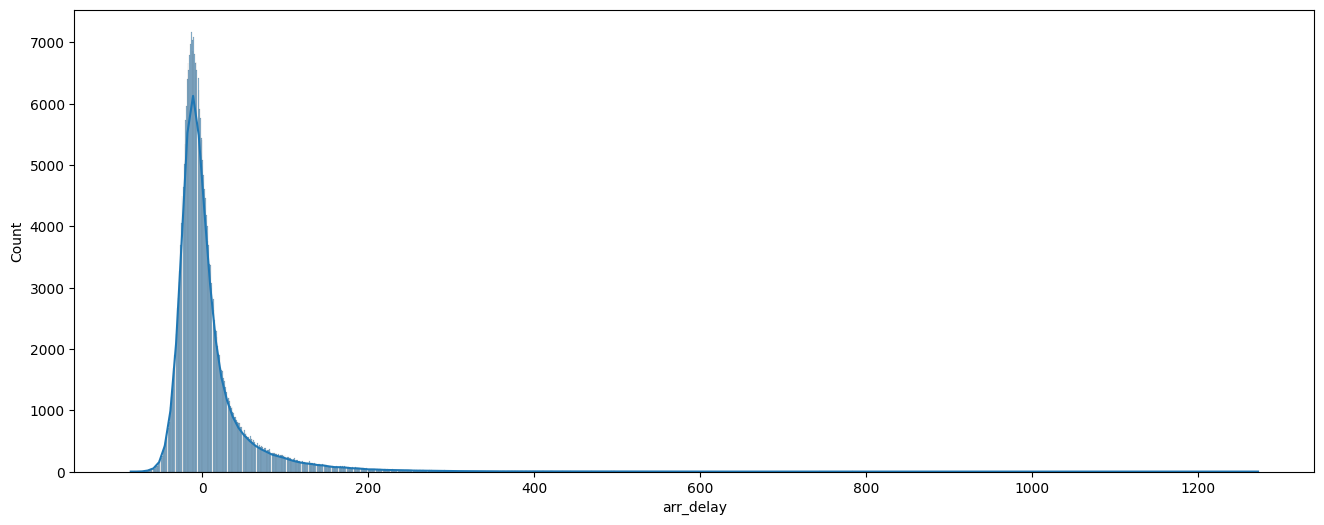

In [15]:
# examaing flight delay distribution
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x="arr_delay", kde=True)
plt.show()

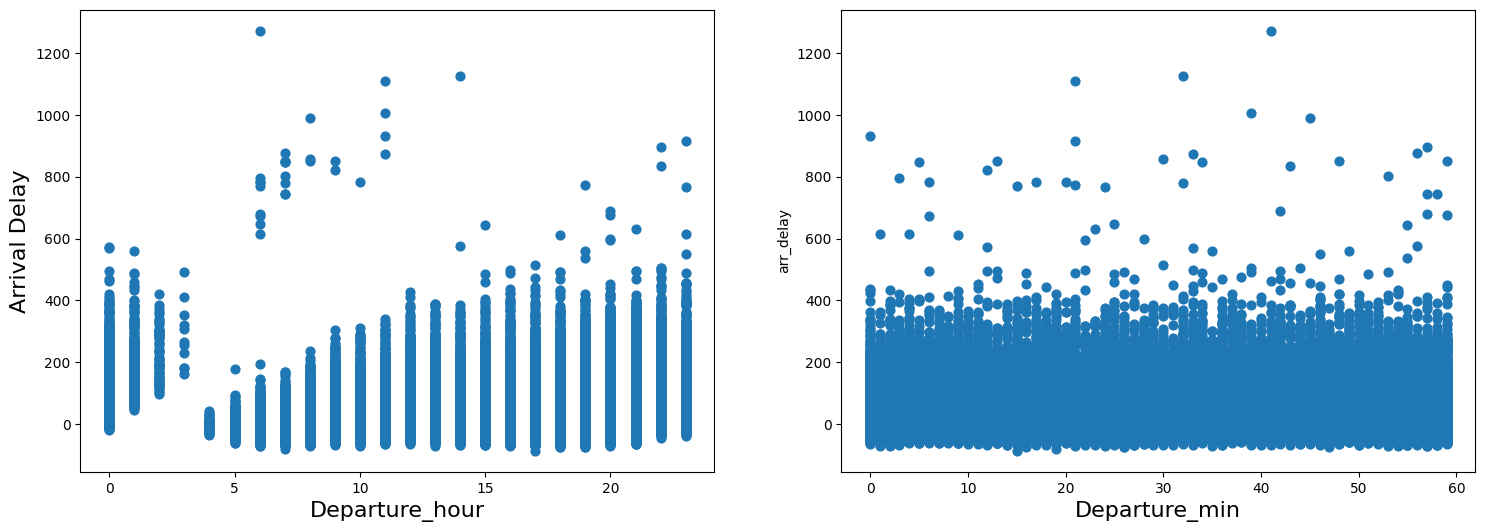

In [16]:
# plotting Departure time relationship to flight delay
fig, axes = plt.subplots(nrows=1, ncols=2)

df.plot(ax=axes[0], kind = 'scatter', x='Departure_hour',y='arr_delay',figsize=(18,6),stacked=True,s=40)
df.plot(ax=axes[1], kind = 'scatter', x='Departure_min',y='arr_delay',figsize=(18, 6),stacked=True,s=40)

axes[0].set_ylabel('Arrival Delay',fontsize=16)
axes[0].set_xlabel('Departure_hour',fontsize=16)
axes[1].set_xlabel('Departure_min',fontsize=16)
plt.show()

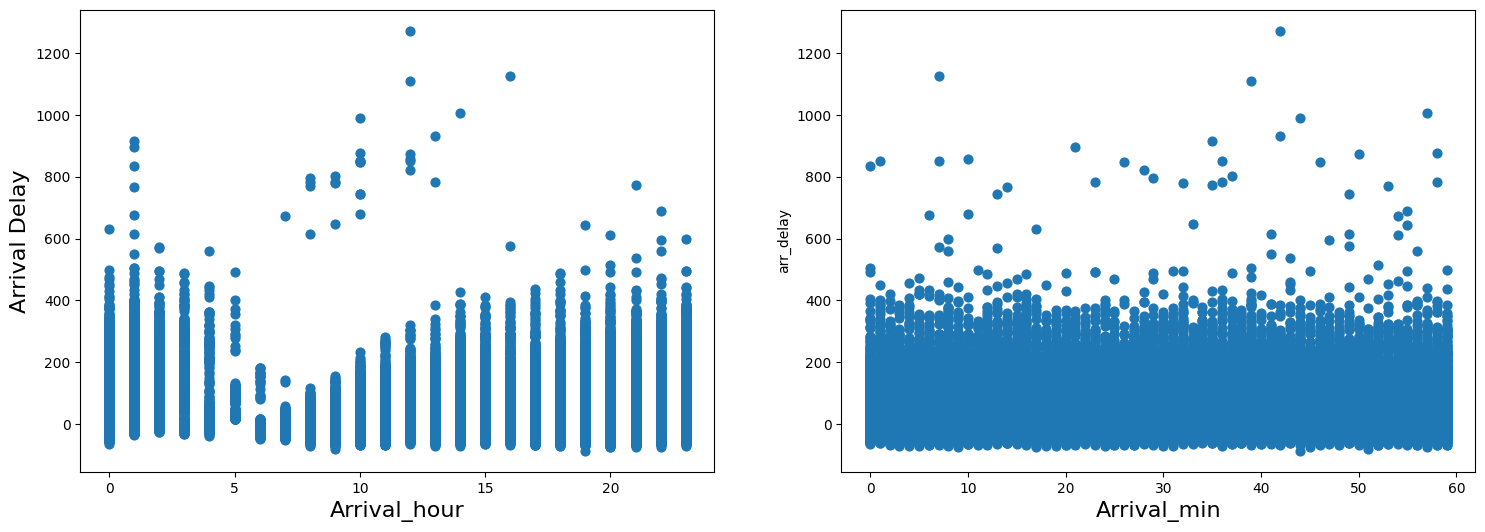

In [17]:
# plotting arrival time relationship to flight delay
fig, axes = plt.subplots(nrows=1, ncols=2)

df.plot(ax=axes[0], kind = 'scatter', x='Arrival_hour',y='arr_delay',figsize=(18,6),stacked=True,s=40)
df.plot(ax=axes[1], kind = 'scatter', x='Arrival_min',y='arr_delay',figsize=(18, 6),stacked=True,s=40)

axes[0].set_ylabel('Arrival Delay',fontsize=16)
axes[0].set_xlabel('Arrival_hour',fontsize=16)
axes[1].set_xlabel('Arrival_min',fontsize=16)
plt.show()

<Axes: title={'center': 'Day_of_Week to Flight Delay'}, xlabel='Day_of_Week', ylabel='arr_delay'>

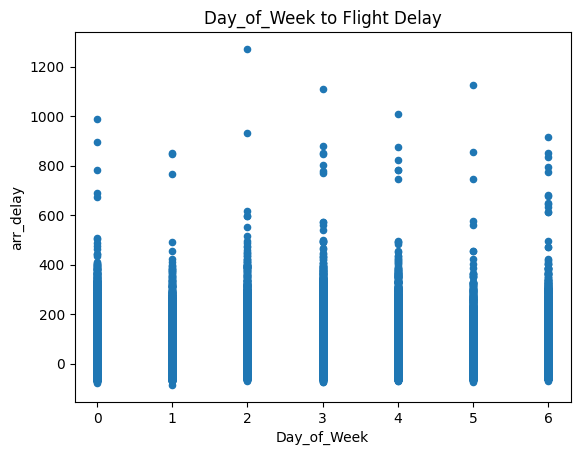

In [18]:
# plotting day of the week relationship to flight delay
df.plot(kind='scatter',
        x='Day_of_Week',
        y='arr_delay',
        title='Day_of_Week to Flight Delay')

<Axes: title={'center': 'Distance to Flight Delay'}, xlabel='distance', ylabel='arr_delay'>

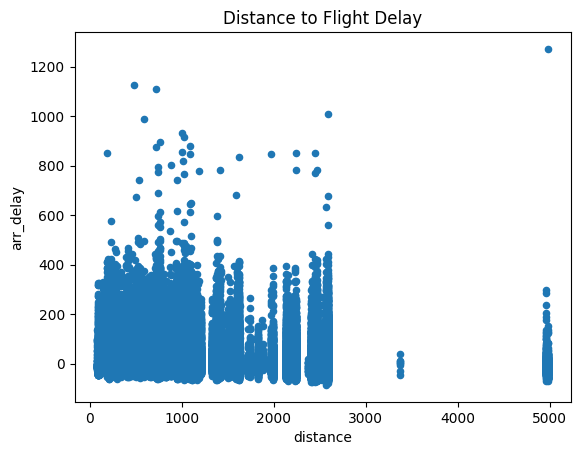

In [19]:
# plotting distance relationship to flight delay
df.plot(kind='scatter',
        x='distance',
        y='arr_delay',
        title='Distance to Flight Delay')

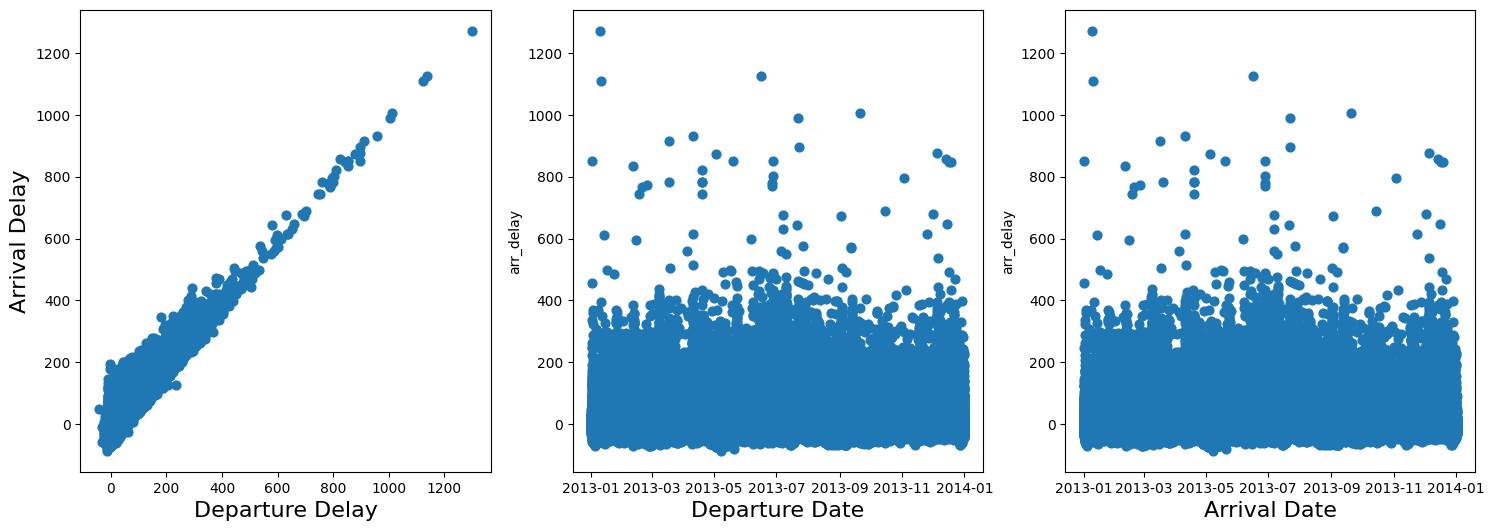

In [20]:
# plotting Departure Delay and Dates relationship to flight delay
fig, axes = plt.subplots(nrows=1, ncols=3)

df.plot(ax=axes[0], kind = 'scatter', x='dep_delay',y='arr_delay',figsize=(18,6),stacked=True,s=40)
df.plot(ax=axes[1], kind = 'scatter', x='Std_Departure_Date',y='arr_delay',figsize=(18, 6),stacked=True,s=40)
df.plot(ax=axes[2], kind = 'scatter', x='Std_Arrival_Date',y='arr_delay',figsize=(18, 6),stacked=True,s=40)

axes[0].set_ylabel('Arrival Delay',fontsize=16)
axes[0].set_xlabel('Departure Delay',fontsize=16)
axes[1].set_xlabel('Departure Date',fontsize=16)
axes[2].set_xlabel('Arrival Date',fontsize=16)
plt.show()

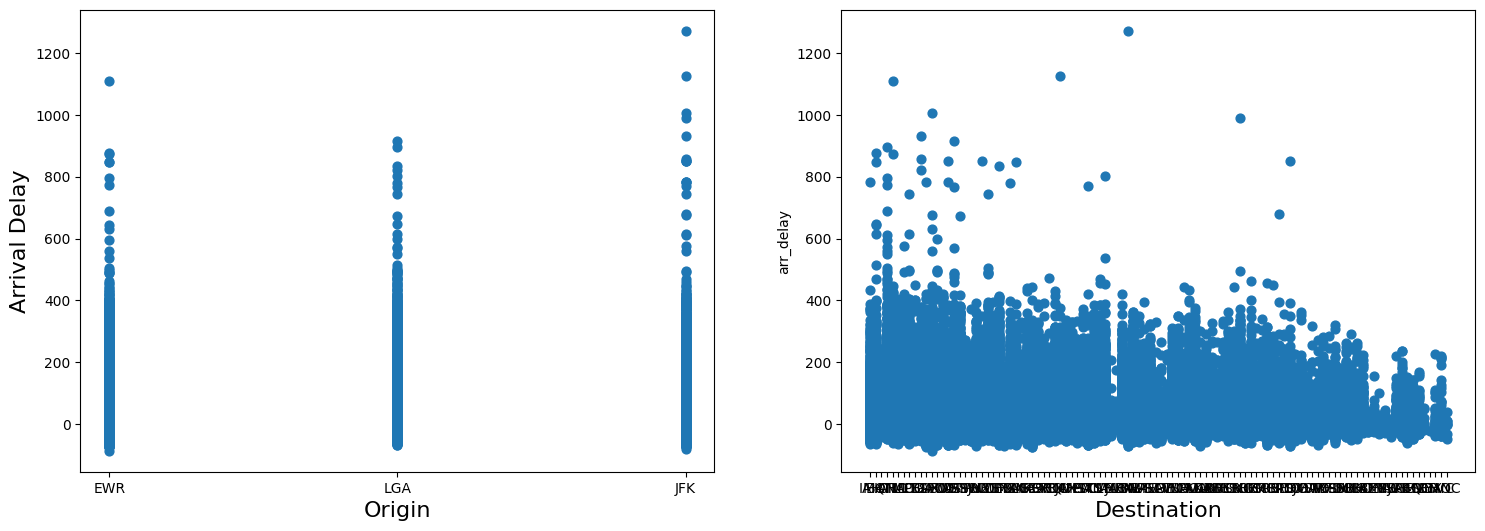

In [21]:
# plotting Origin and Destination relationship to flight delay
fig, axes = plt.subplots(nrows=1, ncols=2)

df.plot(ax=axes[0], kind = 'scatter', x='origin',y='arr_delay',figsize=(18,6),stacked=True,s=40)
df.plot(ax=axes[1], kind = 'scatter', x='dest',y='arr_delay',figsize=(18, 6),stacked=True,s=40)

axes[0].set_ylabel('Arrival Delay',fontsize=16)
axes[0].set_xlabel('Origin',fontsize=16)
axes[1].set_xlabel('Destination',fontsize=16)
plt.show()

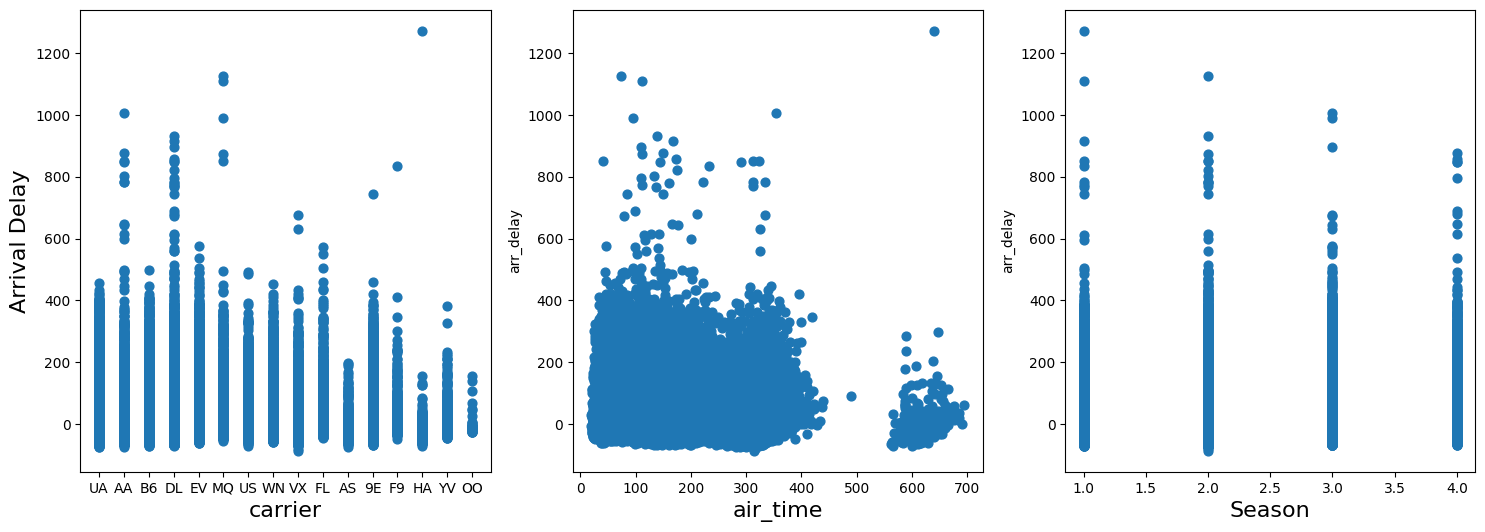

In [22]:
# plotting Departure Delay and Dates relationship to flight delay
fig, axes = plt.subplots(nrows=1, ncols=3)

df.plot(ax=axes[0], kind = 'scatter', x='carrier',y='arr_delay',figsize=(18,6),stacked=True,s=40)
df.plot(ax=axes[1], kind = 'scatter', x='air_time',y='arr_delay',figsize=(18, 6),stacked=True,s=40)
df.plot(ax=axes[2], kind = 'scatter', x='Season',y='arr_delay',figsize=(18, 6),stacked=True,s=40)

axes[0].set_ylabel('Arrival Delay',fontsize=16)
axes[0].set_xlabel('carrier',fontsize=16)
axes[1].set_xlabel('air_time',fontsize=16)
axes[2].set_xlabel('Season',fontsize=16)
plt.show()

##more on these diagrams later.

##ratio:
## 'air time' and 'distance' ration should be somehow fixed number since there are no redlight in the air! so deviation from a fixed number in their devision maybe convay some meaning:

In [23]:
df['time_distance_ratio'] = df['air_time'] / df['distance']

In [24]:
df.time_distance_ratio.describe()

count    327346.000000
mean          0.156667
std           0.030760
min           0.085302
25%           0.136729
50%           0.148459
75%           0.167556
max           0.781250
Name: time_distance_ratio, dtype: float64

##as you can see, it has very little deviation from it's mean value. let's see the histogram:

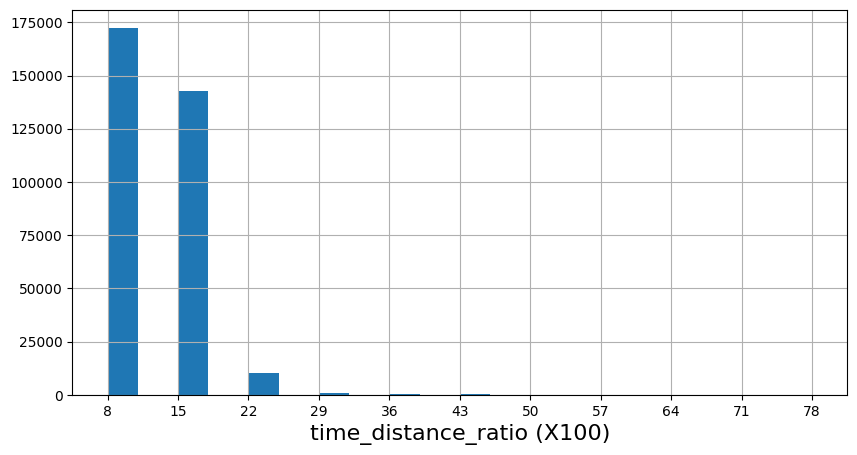

In [25]:
no_bins = 10
min_bin_value = int(df['time_distance_ratio'].mul(100).min())
max_bin_value = int(df['time_distance_ratio'].mul(100).max())+1
bin_width = int((max_bin_value-min_bin_value)/no_bins)
predefined_bins = list(range(min_bin_value,max_bin_value,bin_width))

# Create histogram
df['time_distance_ratio'].mul(100).hist(width=int(bin_width/2),bins=predefined_bins,figsize=(10,5))
plt.xlabel('time_distance_ratio (X100)',fontsize=16)
plt.xticks(predefined_bins)
plt.show()

##binning:
##exact distance and flight time have broad range and maybe it is good prctice to bin them into some disctete values:

In [26]:
df['distance'].unique().size

213

In [27]:
df['distance'].describe()

count    327346.000000
mean       1048.371314
std         735.908523
min          80.000000
25%         509.000000
50%         888.000000
75%        1389.000000
max        4983.000000
Name: distance, dtype: float64

In [28]:
no_bins = 10
bin_step = int((df['distance'].max() - df['distance'].min())/no_bins)
bins = np.arange(int(df['distance'].min()),int(df['distance'].max()) + 1, bin_step)
labels = [1,2,3,4,5,6,7,8,9,10]
df['Binned_distance'] = pd.cut(df['distance'], bins=bins, labels=labels)

In [29]:
df[['distance','Binned_distance']]

,distance,Binned_distance
0,1400,3
1,1416,3
2,1089,3
3,1576,4
4,762,2
...,...,...
336765,209,1
336766,301,1
336767,264,1
336768,187,1


In [30]:
df['air_time'].unique().size

509

In [31]:
df['air_time'].describe()

count    327346.000000
mean        150.686460
std          93.688305
min          20.000000
25%          82.000000
50%         129.000000
75%         192.000000
max         695.000000
Name: air_time, dtype: float64

In [32]:
no_bins = 10
bin_step = int((df['air_time'].max() - df['air_time'].min())/no_bins)
bins = np.arange(int(df['air_time'].min()),int(df['air_time'].max()) + 1, bin_step)
labels = [1,2,3,4,5,6,7,8,9,10]
df['Binned_air_time'] = pd.cut(df['air_time'], bins=bins, labels=labels)

In [33]:
df[['distance','Binned_distance']]

,distance,Binned_distance
0,1400,3
1,1416,3
2,1089,3
3,1576,4
4,762,2
...,...,...
336765,209,1
336766,301,1
336767,264,1
336768,187,1


##combining columns:
##in our dataset, departure delay has added to arrival delay. it means that if you had a 10 min delay in departure and 20 min delay in arrival, your arrival delay will be 30. in a sense, "arrival" delay is "total delay". it is better to have them seperated. so we rename 'arrival delay' to 'total delay' and generate new 'arrival delay'.

In [34]:
df.rename(columns={'arr_delay': 'Total_delay'}, inplace=True)

In [35]:
df['arrival_delay'] = df['Total_delay'] - df['dep_delay']

In [36]:
df['arrival_delay'].describe()

count    327346.000000
mean         -5.659779
std          18.043648
min        -109.000000
25%         -17.000000
50%          -7.000000
75%           3.000000
max         196.000000
Name: arrival_delay, dtype: float64

In [37]:
df['dep_delay'].describe()

count    327346.000000
mean         12.555156
std          40.065688
min         -43.000000
25%          -5.000000
50%          -2.000000
75%          11.000000
max        1301.000000
Name: dep_delay, dtype: float64

In [38]:
df['Total_delay'].describe()

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: Total_delay, dtype: float64

##Target Encoding:

In [39]:
df['origin'].unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [40]:
df['dest'].unique()

array(['IAH', 'MIA', 'BQN', 'ATL', 'ORD', 'FLL', 'IAD', 'MCO', 'PBI',
       'TPA', 'LAX', 'SFO', 'DFW', 'BOS', 'LAS', 'MSP', 'DTW', 'RSW',
       'SJU', 'PHX', 'BWI', 'CLT', 'BUF', 'DEN', 'SNA', 'MSY', 'SLC',
       'XNA', 'MKE', 'SEA', 'ROC', 'SYR', 'SRQ', 'RDU', 'CMH', 'JAX',
       'CHS', 'MEM', 'PIT', 'SAN', 'DCA', 'CLE', 'STL', 'MYR', 'JAC',
       'MDW', 'HNL', 'BNA', 'AUS', 'BTV', 'PHL', 'STT', 'EGE', 'AVL',
       'PWM', 'IND', 'SAV', 'CAK', 'HOU', 'LGB', 'DAY', 'ALB', 'BDL',
       'MHT', 'MSN', 'GSO', 'CVG', 'BUR', 'RIC', 'GSP', 'GRR', 'MCI',
       'ORF', 'SAT', 'SDF', 'PDX', 'SJC', 'OMA', 'CRW', 'OAK', 'SMF',
       'TYS', 'PVD', 'DSM', 'PSE', 'TUL', 'BHM', 'OKC', 'CAE', 'HDN',
       'BZN', 'MTJ', 'EYW', 'PSP', 'ACK', 'BGR', 'ABQ', 'ILM', 'MVY',
       'SBN', 'LEX', 'CHO', 'TVC', 'ANC'], dtype=object)

In [41]:
df['dest'].unique().size

104

##so there are 3 origin and about 100 destination

In [42]:
means = df.groupby('origin')['dep_delay'].mean()
df['origin_departure_delay_Mean'] = df['origin'].map(means)
df.sort_values(by=['origin_departure_delay_Mean'], ascending=True,inplace=True)
df['origin_Target_Encoded'] = df['origin_departure_delay_Mean'].astype('category').cat.codes

In [43]:
df['origin_Target_Encoded'].describe()

count    327346.000000
mean          1.048838
std           0.815104
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: origin_Target_Encoded, dtype: float64

In [44]:
means = df.groupby('dest')['arrival_delay'].mean()
df['dest_arrival_delay_Mean'] = df['dest'].map(means)
df.sort_values(by=['dest_arrival_delay_Mean'], ascending=True,inplace=True)
df['destination_Target_Encoded'] = df['dest_arrival_delay_Mean'].astype('category').cat.codes

In [45]:
df['destination_Target_Encoded'].describe()

count    327346.000000
mean         53.908751
std          25.039193
min           0.000000
25%          33.000000
50%          50.000000
75%          74.000000
max         103.000000
Name: destination_Target_Encoded, dtype: float64

In [46]:
# droping dummy columns
df.drop(columns=['origin_departure_delay_Mean', 'destination_Target_Encoded'], inplace=True)

##counts and aggregation:
##we can calculate mean of departure and arrival delay based on origin(for departure) and destination(for arrival) delay and calculate deviation:

In [47]:
df['avg_arrival_origin'] = df['arrival_delay'].groupby(df['origin']).transform('mean')

In [48]:
df['avg_arrival_origin']

163693   -5.902055
108103   -5.902055
131009   -5.902055
22036    -5.902055
150501   -5.902055
            ...   
100631   -4.503095
8654     -5.902055
307345   -5.902055
125864   -5.902055
23174    -5.902055
Name: avg_arrival_origin, Length: 327346, dtype: float64

##function of columns:
##except of departure delay that obviously has linear relationship with arrival delay(because it adds up to arrival delay) no Bold realtion ship can be seen. however we know that 10 minutes out of 20 minute delay is a lot more than 10 minute out of 10 hour delay! so it's logical to add logarithm of total delay as a new column and choose it as our reference:

In [49]:
df['Total_delay_log'] = np.where(df['Total_delay'] < 0, 0, np.log2(df['Total_delay'] + 1))
df['Total_delay_log'].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    327346.000000
mean          1.798422
std           2.432772
min           0.000000
25%           0.000000
50%           0.000000
75%           3.906891
max          10.314017
Name: Total_delay_log, dtype: float64

In [50]:
df['Total_delay'].describe()

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: Total_delay, dtype: float64

##as we can see most of the delays are negative(what kind of country is this! :) )so we should consider negative values too:

In [51]:
df['Total_delay_log'] = np.where(df['Total_delay'] < 0, -np.log2(-df['Total_delay']), np.log2(df['Total_delay'] + 1))
df['Total_delay_log'].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    327346.000000
mean         -0.303300
std           4.192416
min          -6.426265
25%          -4.087463
50%          -2.321928
75%           3.906891
max          10.314017
Name: Total_delay_log, dtype: float64

##mutual information:

In [52]:
#convert all values to numerical
for colname in df.select_dtypes("object"):
    df[colname], _ = df[colname].factorize()
df.dropna(inplace=True)
#pop the target values
target_column = df.pop("Total_delay")

In [56]:
df = df.drop(['Std_Arrival_Date','Std_Departure_Date'],axis=1)

In [57]:
feature_selector = SelectKBest(score_func=mutual_info_regression, k = 'all').fit(df,target_column)

<Axes: ylabel='Feature'>

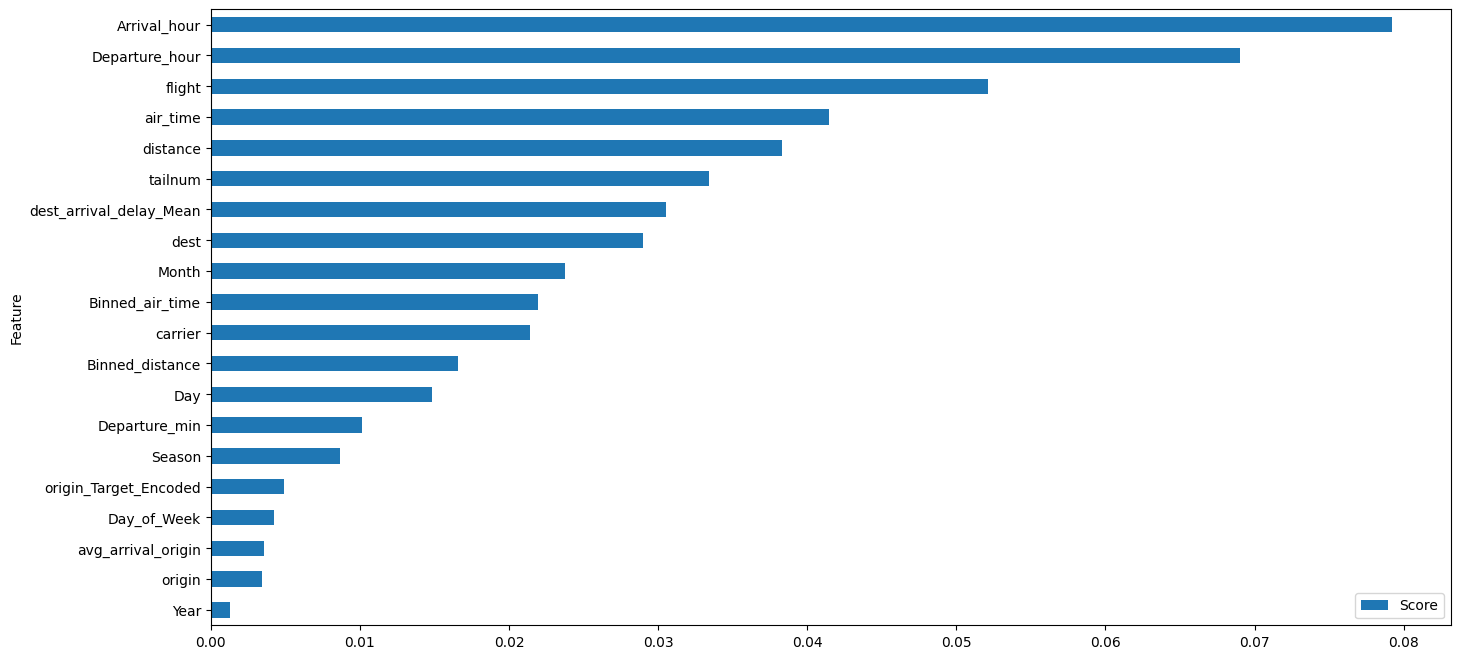

In [58]:
feature_scores = pd.DataFrame({'Feature':df.columns,'Score':feature_selector.scores_})
feature_scores.sort_values(by=['Score'],inplace=True)

feature_scores[0:20].plot(x='Feature',y='Score',kind='barh',figsize=(16,8))

##and as someone can expect, arrival and departure hour are most related to flight delay(think about that as there is rush hours for airplanes!)
##also,one can use origin and destination as usefull sources for pridicting the delay. the score for origin is so small because there is just 3 origin (there is 104 destination, for comparison).

##PCA:

In [60]:
normalized_df = StandardScaler().fit_transform(df)

In [64]:
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(normalized_df)
df_pca = pd.DataFrame(data = normalized_df)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.734925,-1.135039,-0.962168,-1.444364,-1.173147,-2.156361,1.068352,1.035139,0.0,-1.044762,...,-0.321000,0.952515,-0.585531,1.015499,1.142573,-0.850813,1.166467,-3.731857,-0.300601,1.663544
1,0.360811,-1.135039,-0.864699,-1.443435,-1.173147,-2.156361,1.014281,1.035139,0.0,1.592130,...,-0.508398,0.318799,-0.676388,1.015499,1.142573,-1.682443,1.166467,-3.731857,-0.300601,-0.684110
2,-0.238965,-1.135039,-0.899862,-1.442507,-1.173147,-2.156361,1.176495,1.035139,0.0,-1.337750,...,-0.508398,-1.582348,-0.403817,1.015499,1.142573,0.368910,1.166467,-3.731857,-0.300601,0.625839
3,-0.163993,-1.135039,-0.899862,-1.441579,-1.173147,-2.156361,1.122424,1.035139,0.0,-1.630737,...,-0.695795,0.952515,-0.494674,1.015499,1.142573,-0.850813,1.166467,-3.731857,-0.300601,-0.859895
4,-0.388910,-1.135039,-0.899862,-1.440651,-1.173147,-2.156361,1.490110,1.035139,0.0,-1.044762,...,-0.508398,0.088357,0.123154,1.015499,1.142573,2.198494,1.166467,-3.731857,-0.300601,1.264628


Text(0.5, 1.0, 'PCA Feature Selection')

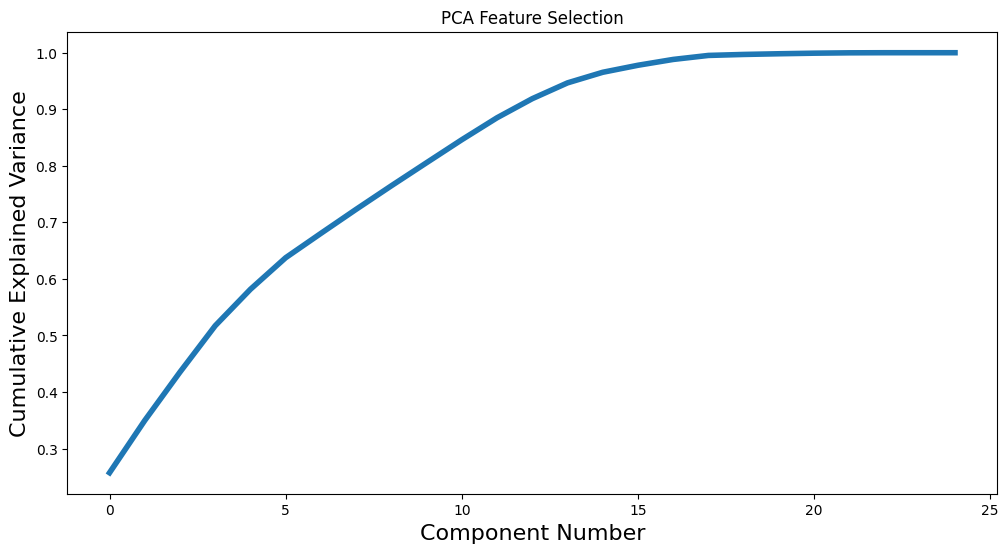

In [68]:
figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),lw=4)
plt.xlabel('Component Number',fontsize=16)
plt.ylabel('Cumulative Explained Variance',fontsize=16)
plt.title('PCA Feature Selection')

##it seems that 15 features would do the job!

##Question: when is feature engineering a “nice to have option” and in what situations it is a “must to have”?
##in real situations, somtimes feature engineering help the "Model" to infer more quickly since the infered new feature(that generated by "US") is hard for Model to infer. examples are some math relationships like division. in these cases, feature engineering is "nice To Have"
##there are cases when available features are in the order of hundreds to even thousands and milions! in these cases feature engineering thechniques like PCA is a must so our model could run appropriately on commodity hardware. feature engineering is also the case when the data is not enough to train the model...